In [1]:
# 导入需要的模块
import requests
from bs4 import BeautifulSoup
import pandas as pd, numpy as np
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# 利用新浪财经获取国内基金数据

In [7]:
#指定默认字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family']='sans-serif'
#解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False

# 抓取网页
def get_url(url, params=None, proxies=None):
    rsp = requests.get(url, params=params, proxies=proxies)
    rsp.raise_for_status()
    return rsp.text

# 从网页抓取数据
def get_fund_data(code,per=10,sdate='',edate='',proxies=None):
    url = 'http://fund.eastmoney.com/f10/F10DataApi.aspx'
    params = {'type': 'lsjz', 'code': code, 'page':1,'per': per, 'sdate': sdate, 'edate': edate}
    html = get_url(url, params, proxies)
    soup = BeautifulSoup(html, 'html.parser')

    # 获取总页数
    pattern=re.compile(r'pages:(.*),')
    result=re.search(pattern,html).group(1)
    pages=int(result)

    # 获取表头
    heads = []
    for head in soup.findAll("th"):
        heads.append(head.contents[0])

    # 数据存取列表
    records = []

    # 从第1页开始抓取所有页面数据
    page=1
    while page<=pages:
        params = {'type': 'lsjz', 'code': code, 'page':page,'per': per, 'sdate': sdate, 'edate': edate}
        html = get_url(url, params, proxies)
        soup = BeautifulSoup(html, 'html.parser')

        # 获取数据
        for row in soup.findAll("tbody")[0].findAll("tr"):
            row_records = []
            for record in row.findAll('td'):
                val = record.contents

                # 处理空值
                if val == []:
                    row_records.append(np.nan)
                else:
                    row_records.append(val[0])

            # 记录数据
            records.append(row_records)

        # 下一页
        page=page+1

    # 数据整理到dataframe
    np_records = np.array(records)
    data= pd.DataFrame()
    for col,col_name in enumerate(heads):
        data[col_name] = np_records[:,col]

    return data

In [3]:
(600+221+100)/8000

0.115125

No handles with labels found to put in legend.
No handles with labels found to put in legend.


          净值日期   单位净值   累计净值  日增长率  申购状态  赎回状态 分红送配
0   2020-01-02  2.025  2.240  0.40  开放申购  开放赎回  nan
1   2020-01-03  2.018  2.233 -0.35  开放申购  开放赎回  nan
2   2020-01-06  2.010  2.225 -0.40  开放申购  开放赎回  nan
3   2020-01-07  2.048  2.263  1.89  开放申购  开放赎回  nan
4   2020-01-08  2.039  2.254 -0.44  开放申购  开放赎回  nan
..         ...    ...    ...   ...   ...   ...  ...
267 2021-02-05  4.352  4.567  3.13  开放申购  开放赎回  nan
268 2021-02-08  4.425  4.640  1.68  开放申购  开放赎回  nan
269 2021-02-09  4.502  4.717  1.74  开放申购  开放赎回  nan
270 2021-02-10  4.647  4.862  3.22  开放申购  开放赎回  nan
271 2021-02-18  4.389  4.604 -5.55  开放申购  开放赎回  nan

[272 rows x 7 columns]


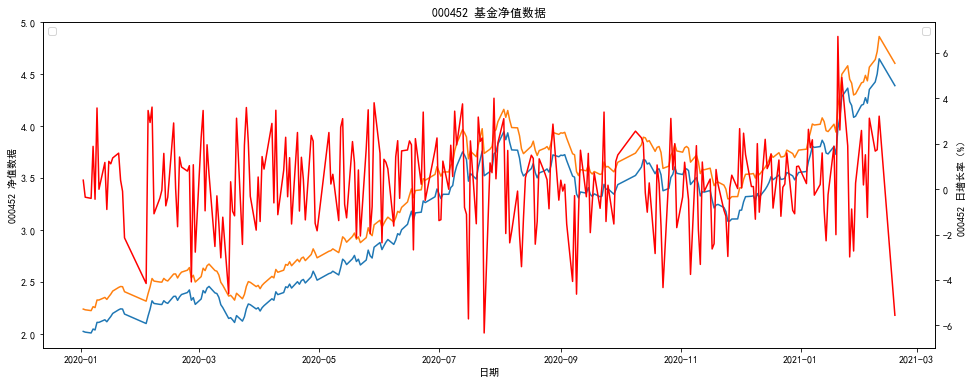

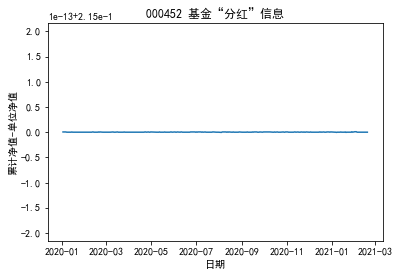

日增长率缺失： 0
日增长率为正的天数： 159
日增长率为负（包含0）的天数： 113


In [3]:
# 主程序
if __name__ == "__main__":
    ticker = '000452'
    data=get_fund_data(ticker,per=49,sdate='2020-01-01',edate='2021-2-19')
    # 修改数据类型
    data['净值日期']=pd.to_datetime(data['净值日期'],format='%Y/%m/%d')
    data['单位净值']= data['单位净值'].astype(float)
    data['累计净值']=data['累计净值'].astype(float)
    data['日增长率']=data['日增长率'].str.strip('%').astype(float)
    # 按照日期升序排序并重建索引
    data=data.sort_values(by='净值日期',axis=0,ascending=True).reset_index(drop=True)
    print(data)

    # 获取净值日期、单位净值、累计净值、日增长率等数据并
    net_value_date = data['净值日期']
    net_asset_value = data['单位净值']
    accumulative_net_value=data['累计净值']
    daily_growth_rate = data['日增长率']

    # 作基金净值图
    fig = plt.figure(figsize = (16,6))
    #坐标轴1
    ax1 = fig.add_subplot(111)
    ax1.plot(net_value_date,net_asset_value)
    ax1.plot(net_value_date,accumulative_net_value)
    ax1.set_ylabel('{} 净值数据'.format(ticker))
    ax1.set_xlabel('日期')
    plt.legend(loc='upper left')
    #坐标轴2
    ax2 = ax1.twinx()
    ax2.plot(net_value_date,daily_growth_rate,'r')
    ax2.set_ylabel('{} 日增长率（%）'.format(ticker))
    plt.legend(loc='upper right')
    plt.title('{} 基金净值数据'.format(ticker))
    plt.show()

    # 绘制分红配送信息图
    bonus = accumulative_net_value-net_asset_value
    plt.figure()
    plt.plot(net_value_date,bonus)
    plt.xlabel('日期')
    plt.ylabel('累计净值-单位净值')
    plt.title('{} 基金“分红”信息'.format(ticker))
    plt.show()

    # 日增长率分析
    print('日增长率缺失：',sum(np.isnan(daily_growth_rate)))
    print('日增长率为正的天数：',sum(daily_growth_rate>0))
    print('日增长率为负（包含0）的天数：',sum(daily_growth_rate<=0))

In [3]:
ticker_list = list(set(['161725','009865','003096']))

In [4]:
ticker_list

['161725', '003096', '009865']

In [45]:
ticker_list = list(set(['161725','009865','003096','011609','005827','001838','110011',
                       '006792','010849','161005','010358','000452','001508','004233',
                       '001888']))
start_date = '2020-01-01'
end_date = '2021-03-03'


def read_data_from_Sina(ticker_list, start_date, end_date):
    data_list = []
    load_count = 1
    len_tickers = len(ticker_list)
    for ticker in ticker_list:
        if load_count%100==0:
            print("=======================Sleeping======================")
            time.sleep(30)
        else:
            print("Loading from SinaFinance: No.{} / {}: {}".format(load_count, len_tickers, ticker))
            data=get_fund_data(ticker,per=49,sdate=start_date,edate=end_date)
            # 修改数据类型
            data['净值日期']=pd.to_datetime(data['净值日期'],format='%Y/%m/%d')
            data['单位净值']= data['单位净值'].astype(float)

            # 按照日期升序排序并重建索引
            data=data.sort_values(by='净值日期',axis=0,ascending=True).reset_index(drop=True)
            data = data[['净值日期','单位净值']]
            data.columns = ['Date', 'Adj Close']
            data['Ticker'] = ticker
            data_list.append(data)
        load_count+=1
    print("All Data Loaded")
    return data_list

In [43]:
data_list = read_data_from_Sina(ticker_list, start_date, end_date)

Loading from SinaFinance: No.1 / 15: 001508
Loading from SinaFinance: No.2 / 15: 005827
Loading from SinaFinance: No.3 / 15: 001838
Loading from SinaFinance: No.4 / 15: 010358
Loading from SinaFinance: No.5 / 15: 004233
Loading from SinaFinance: No.6 / 15: 001888
Loading from SinaFinance: No.7 / 15: 009865
Loading from SinaFinance: No.8 / 15: 161005
Loading from SinaFinance: No.9 / 15: 110011
Loading from SinaFinance: No.10 / 15: 161725
Loading from SinaFinance: No.11 / 15: 003096
Loading from SinaFinance: No.12 / 15: 011609
Loading from SinaFinance: No.13 / 15: 006792
Loading from SinaFinance: No.14 / 15: 000452
Loading from SinaFinance: No.15 / 15: 010849
All Data Loaded


In [15]:
data

,净值日期,单位净值,累计净值,日增长率,申购状态,赎回状态,分红送配
0,2020-05-06,0.9806,2.1067,0.74,限制大额申购,开放赎回,nan
1,2020-05-07,0.9923,2.1184,1.19,限制大额申购,开放赎回,nan
2,2020-05-08,1.0021,2.1282,0.99,限制大额申购,开放赎回,nan
3,2020-05-11,1.0049,2.1310,0.28,限制大额申购,开放赎回,nan
4,2020-05-12,1.0082,2.1343,0.33,限制大额申购,开放赎回,nan
...,...,...,...,...,...,...,...
196,2021-02-24,1.3567,2.9878,-5.52,开放申购,开放赎回,nan
197,2021-02-25,1.3373,2.9684,-1.43,开放申购,开放赎回,nan
198,2021-02-26,1.2999,2.9310,-2.80,开放申购,开放赎回,nan
199,2021-03-01,1.3075,2.9386,0.58,开放申购,开放赎回,nan
